# Project 3: MCMC and Statistical Mechanics

## Write a Python module to run MCMC simulations

Imagine that you are playing a game with your friend in which you roll a 6-sided die.  The way the game works is that every time the die lands on side 1 or side 2, you win one dollar, and every time the die lands on side 3, 4, 5, or 6, your friend wins one dollar.  Because you really want to win the game at all costs, you decide to cheat and use a weighted die.  This means that the side is preferentially weighted so that sides 1 and 2 are each three times more likely to land face up than sides 3, 4, 5, and 6.  In other words, if $p_k$ denotes the probability that side $k$ will land face up, then

\begin{align}
    p_1 = p_2, \qquad p_3 = p_4 = p_5 = p_6 \qquad p_1 = 3 p_3.
\end{align}

Your module should contain a function

    weighted_die(num_steps)

That runs an Markov Chain Monte Carlo (MCMC) simulation to simulate the results of rolling the die above a large number of times.  The argument `num_steps` tells the simulation how many MCMC updates you want to perform.  The simulation should keep track of your winnings (an integer dollar amount) in the game after each update, and it should return the approximate expected value (average) of your earnings in the game.  Note that you should be able to figure out the expected value of your earnings analytically in this case and compare this to what your simulation produces as a sanity check.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

def weighted_die(num_steps):
    out = []
    p = np.array([3,3,1,1,1,1])
    p = p / np.sum(p)

    # generate a uniform random between 0 and 1
    # if it is less than 0.5, move left, else move right

    curr = np.random.choice([0,1,2,3,4,5])
    curr_prob = p[curr]

    for i in range(num_steps):
        if np.random.rand() < 0.5:
            nex = curr - 1 if curr > 0 else 5
        else:
            nex = curr + 1 if curr < 5 else 0
        
        nex_prob = p[nex]

        # p(x*)/p(x^n)
        acceptance = nex_prob / curr_prob

        if np.random.rand() <= acceptance:
            curr = nex
            curr_prob = nex_prob

        out.append(curr)
    
    out = [value + 1 for value in out]

    return out

def weighted_die_direct_sampling(num_steps):
    sides = [1, 2, 3, 4, 5, 6]
    weights = [3, 3, 1, 1, 1, 1]  # The weight of each die side
    
    results = []
    for _ in range(num_steps):
        # Selects a side based on the provided weights
        roll = random.choices(sides, weights=weights, k=1)[0]
        results.append(roll)
    
    return results


num_simulation = int(1e6)
result_mcmc = weighted_die(num_simulation)
result_python = weighted_die_direct_sampling(num_simulation)


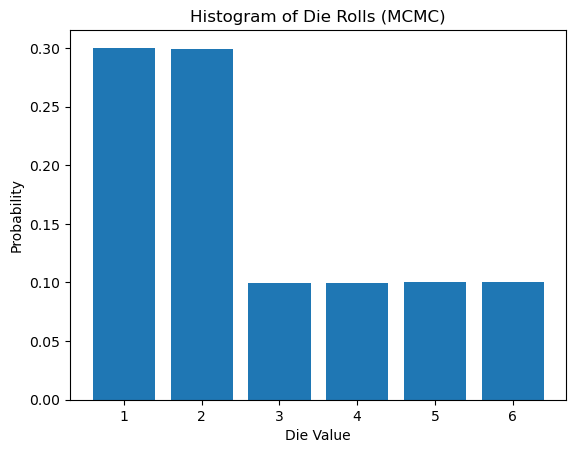

In [2]:
# Set bins to explicitly represent each die value from 1 to 6
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]  # Setting bins between the integers
plt.hist(result_mcmc, bins=bins, density=True, rwidth=0.8)
plt.xticks(range(1, 7)) 
plt.xlabel('Die Value')
plt.ylabel('Probability')
plt.title('Histogram of Die Rolls (MCMC)')
plt.show()

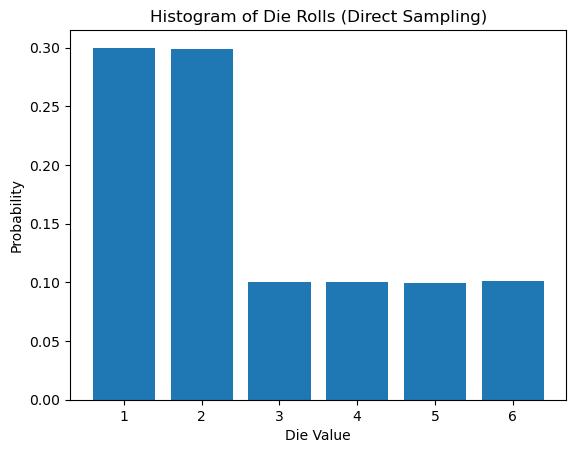

In [3]:
plt.hist(result_python, bins=bins, density=True, rwidth=0.8)
plt.xticks(range(1, 7))  # Set x-ticks to be centered on each integer
plt.xlabel('Die Value')
plt.ylabel('Probability')
plt.title('Histogram of Die Rolls (Direct Sampling)')
plt.show()

Your module should contain a second function

    two_dim_ising(L, temp, num_steps)
    
that simulates the 2-d ising model on a square, periodic lattice of a specified side length (number of spins) `L` and at a given temperature.  The inputs `temp` and `num_steps` specify the desired temperature of the lattice and the number of MCMC updates you wish to perform during the simulation.  The function should return whatever you think is useful in completing the Jupyter notebook described below.

In [4]:
# def two_dim_ising_python(L : int, temp : float, num_steps : int):
#     Lattice_matrix = np.ones((L, L), dtype=int)
#     E_arr = np.empty(num_steps + 1)
#     E_arr[0] = -2 * L**2

#     for step in range(num_steps):
#         i = np.random.randint(L)
#         j = np.random.randint(L)
#         H = 0  # External magnetic field

#         s_i = Lattice_matrix[i, j]
#         s_top = Lattice_matrix[(i - 1) % L, j]
#         s_bot = Lattice_matrix[(i + 1) % L, j]
#         s_left = Lattice_matrix[i, (j - 1) % L]
#         s_right = Lattice_matrix[i, (j + 1) % L]
#         dE = 2 * s_i * (s_top + s_bot + s_left + s_right + H)


#         if dE <= 0 or np.random.rand() < np.exp(-dE/temp):
#             Lattice_matrix[i, j] = -s_i
#             E_arr[step+1] = E_arr[step] - dE
    
#     return Lattice_matrix, E_arr

In [34]:
from numba import jit
@jit(nopython=True)
def two_dim_ising(L : int, temp : float, num_steps : int):
    Lattice_matrix = np.ones((L, L), dtype=np.int32)

    # Energy definition
    E_arr = np.empty(num_steps + 1) # store energy at each step
    E_arr[0] = -2 * L**2 # initial energy

    # Spin definition
    S_arr = np.empty(num_steps + 1)
    S_arr[0] = L**2

    for step in range(num_steps):
        i = np.random.randint(L)
        j = np.random.randint(L)
        H = 0  # external magnetic field

        s_i = Lattice_matrix[i, j]
        s_top = Lattice_matrix[(i - 1) % L, j]
        s_bot = Lattice_matrix[(i + 1) % L, j]
        s_left = Lattice_matrix[i, (j - 1) % L]
        s_right = Lattice_matrix[i, (j + 1) % L]
        dE = 2 * s_i * (s_top + s_bot + s_left + s_right + H)

        # if we accept the change
        if dE <= 0 or np.random.rand() < np.exp(-dE/temp):
            Lattice_matrix[i, j] = -s_i
            E_arr[step+1] = E_arr[step] - dE # energy update
            S_arr[step+1] = S_arr[step] - 2*s_i # spin update     
        # if we dont accept the change
        else:
            E_arr[step+1] = E_arr[step] # energy update
            S_arr[step+1] = S_arr[step] # spin update
    
    return Lattice_matrix, E_arr, S_arr



In [57]:
arr, E, S = two_dim_ising(L = 32, temp = 25, num_steps = int(1e6))

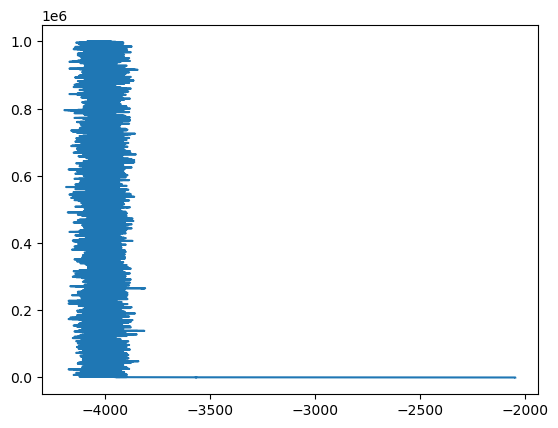

In [58]:
plt.plot(E, np.arange(E.size))
plt.show()

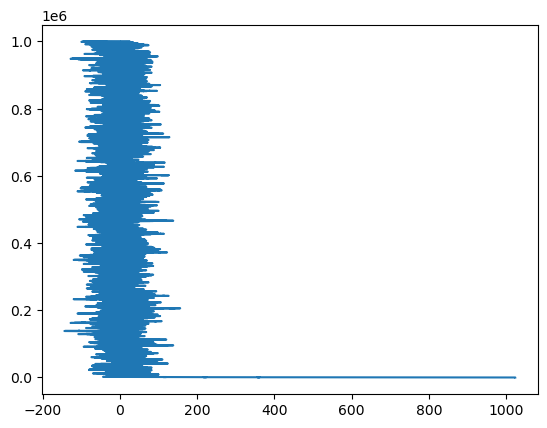

In [59]:
plt.plot(S, np.arange(E.size))
plt.show()

In [ ]:
# # Parameters for the simulation
# L = 8  # Lattice size
# temp = 2.5  # Temperature
# num_steps = int(1e6) # Number of Monte Carlo steps

# # Measure execution time of the Python version
# print("Running Python version:")
# %timeit two_dim_ising_python(L, temp, num_steps)

# # Measure execution time of the Numba version
# print("Running Numba version:")
# %timeit two_dim_ising(L, temp, num_steps)

## Write a Jupyter notebook that explores and describes the physics of the 2d Ising model


Your notebook should apply the function `two_dim_ising` to investigate the physics of the 2d Ising model on an $N = L\times L$ periodic lattice in the absence of an external magnetic field.  Periodicity of the lattice means that if the lattice configuration is represented as an array $s_{ij}$ of spins

\begin{align}
    \begin{pmatrix}
        s_{00} & \cdots & s_{0, L-1} \\
        \vdots & \ddots & \vdots \\
        s_{L-1,0} & \cdots & s_{L-1, L-1} \\
    \end{pmatrix}
\end{align}

Then the nearest neigbors of a spin on the edge are identified by "wrapping the lattice around" to the opposite edge.  For example, for a spin $s_{i, 0}$ on the left edge of the lattice, the nearest neighbor on the left would be $s_{i, L - 1}$, a spin that is on the right edge of the lattice, and similarly for the bottom and top of the lattice.  In this notebook, you will explore the behaviors of the mean internal energy $U$, 
magnetization $M$, specific heat $C_H$, and magnetic susceptibility $\chi_T$ (per lattice site) on the temperature, defined as

\begin{align}
U& = \frac{1}{N}\langle E\rangle ,& M& = \frac{1}{N}\langle S\rangle ,\\
\chi_T& = \frac{1}{NT}\left(\langle S^2\rangle  - \langle S\rangle^2\right),&
C_H& = \frac{1}{NT^2}\left(\langle E^2\rangle - \langle E\rangle^2\right),
\end{align}

where $N=L^2$ is the total number of sites, and $S = \sum_i s_i$ is the net magnetization.  One way to implement the Metropolis-Hastings algorithm for the Ising model on a square lattice is the following:

1. Pick a random site $i$ on the 2D lattice and compute the energy change $\Delta E$ due to the change of 
sign in $s_i$:

    \begin{align}
        \Delta E = 2s_i\bigl(s_{\text{top}} + s_{\text{bottom}} + s_{\text{left}} + s_{\text{right}} + H\bigr),
    \end{align}
    
where $s_{\text{top}}$, $s_{\text{bottom}}$, $s_{\text{left}}$, and $s_{\text{right}}$ are the 4
nearest neighbours of $s_i$.
1. If $\Delta E\leq 0$ accept the move. If $\Delta E>0$ accept the move with probability $A=\exp(-\Delta E/T)$.
1. Flip the spin $s_i$ if the move has been accepted. 
1. Repeat steps 1-3 until you generate a large sample of spin configurations.

To save memory, use new samples $\{s_i\}_{n+1}$ immediately as they arrive to update your estimates according to the rule

\begin{align}
\langle O\rangle_{n+1} = \langle O\rangle_{n} + \frac{1}{n+1}\Bigl(O\bigl(\{s_i\}_{n+1}\bigr) - \langle O\rangle_{n}\Bigr),
\end{align}

where $\langle O\rangle_n$ is the previous estimate for the mean of some observable $O$ obtained from a 
sequence of $n$ samples, and $\langle O\rangle_{n+1}$ is the new improved estimate.
Avoid also updating the energy and magnetization by looping over all sites of the $L\times L$ lattice. 
It is necessary to perform this time-consuming operation only once at the very 
start of the simulation. Afterwards you can keep track of $E$ and $S$ by adding the increments 
$\Delta E$ and $\Delta s$ to the old values.

### Plotting time series' of intensive quantities

As you run your MCMC simulation, you should find that the 
for larger system size, the Monte Carlo simulation needs to run longer steps, to reach equilibrium.  In order to monitor the convergence of values of observables during the simulation, it is helpful to plot their values as a function of time step.  In order to make the benchmarking a fair game, the "updating step per site" is defined as follows:

\begin{align}
    t=\frac{\text{Total updates}}{\text{numbers of sites}}
\end{align}

**What you need to do:**

- Choose system sizes $L = 16, 32$ and a temperature of your choosing not to close to the critical temperature, and run the simulation.  Plot $U$ and $M$ as functions of $t$, the update step per site defined above.  
- Roughly how long does it seem to take for the simulation to converge?  
- Does the time it takes seem to depend on the system size?

### Magnetization curves for different lattice sizes

Onsager's exact solution gives the following result for the magnetization as a function of temperature:

\begin{align}
M(T)& = \begin{cases}\Bigl[1 - \sinh^{-4}\bigl(2/T\bigr)\Bigr]^{1/8},& T<T_c\\
0,& T\geq T_c
\end{cases}
\end{align}

obtained in the thermodynamic limit $N\to\infty$. 

**What you need to do:**

- Consider system sizes $L = 8, 16, 32, 64$. 
- For each size, generate an $M(T)$ curve.  Plot these 4 curves, together with the exact curve, *in the same plot.* - We suggest you start the simulations at a high temperature above the critical point $T_c$  and slowly cool the ferromagnet by decreasing the temperature in small steps. After each update of $T$, perform a large number of iterations with the Metropolis-Hastings algorithm without calculating the ensemble averages. Once the system is close to thermal equilibrium start drawing the samples from the equilibrium distribution and calculate the averages along the way.

**Notes.**

- These are computationally expensive calculations.
- There are 4 curves for different system sizes.
- Each curve is made of many dots. (you decide the spacing of temperatures)
- Each dot is an averaged magnetization per site at a given temperature

### Typical spin configuration at different temperatures

Once the energy and magnetization have come to equilibrium in your simulation, you can look at the configuration of the system to see what a typical configuration of the system looks like in thermal equilibrium.  One way to do this is to make a plot of the whole array of spins with a black or white square representing spin up or spin down.

**What you need to do:**

- Choose your system size to be $L = 256$.  
- Make sure run your simulation enough time steps, until the system is in equilibrium.
- Plot three pictures of spin configuration, at temperature $T=1.8$, $T=2.3$, $T=4.0$.  Your pictures should display the grid of spins with either a black or white square at a given site depending on whether the site is in a spin up state or a spin down state.
- Comment on how the patterns differ at different temperatures and what they might physically tell us about how the system behaves at temperatures below, near, and above the critical temperature.

### Further exploration if you're interested

- Consider the case where the external magnetic field $H$ is nonzero, and investigate the physics of the model.
- Explore the behaviors of $C_H$ and $\chi_T$ in addition to $U$ and $M$ as a function of temperature and lattice size.